In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pint, os
ureg = pint.UnitRegistry()

In [2]:
T = 298 * ureg.kelvin
kB =  1.380649e-23 * ureg.joule/ureg.kelvin # J/K
Na = 6.022141e23/ureg.mol # mol-1
h = 6.626e-34 * ureg.joule*ureg.second # Js
mass_CO2_g_mol = 44.01 * ureg.gram/ureg.mol
mass_CO2 = mass_CO2_g_mol / Na
mass_CO2 = mass_CO2.to_base_units()
deBroglie_wavelength = np.sqrt(h**2/(2*np.pi*mass_CO2*kB*T)).to_base_units()

In [98]:
# Theory
def density_from_mu_id(mu_K, deBroglie_wavelength, kB, T):
    mu_J = (mu_K*kB).to_base_units()
    return np.exp(-mu_J/(kB*T)) / deBroglie_wavelength**3

# Directory scanner
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

def measure_isotherm(dirs, atoms = ["CO2"]):
    density_g_cm3= []
    for dir in dirs:
        mean_density = 0
        for atom in atoms:
            density = np.loadtxt(dir+"/density_"+atom+".dat")[:,1]
            N_end = len(density)//50
            mean_density += np.mean(density[-N_end:]) # g/cm3
        density_g_cm3.append(mean_density)
    density_g_cm3 = np.array(density_g_cm3)
    density_g_cm3 *= ureg.gram/ureg.centimeter**3
    return density_g_cm3

# Folder detector
def scan_directory(dir_lammps):
    subfolders= fast_scandir("./")
    filtered_subfolders = []
    for dir in subfolders:
        if "outputs_" in dir:
            if dir_lammps:
                if "lammps-comparison" in dir:
                    filtered_subfolders.append(dir)
            else:
                if "lammps" not in dir:
                    filtered_subfolders.append(dir) 
    chemical_potentials_K = []
    for dir in filtered_subfolders:
        mu_K = np.float32(dir.split("_")[-1][2:])
        chemical_potentials_K.append(mu_K)
    chemical_potentials_K = np.array(chemical_potentials_K)
    chemical_potentials_K = chemical_potentials_K *ureg.degree_Kelvin
    return filtered_subfolders, chemical_potentials_K

# LAMMPS data

In [99]:
lammps_dir, lammps_mu_K = scan_directory(dir_lammps = True)
lammps_rho_g_cm3 = measure_isotherm(lammps_dir, atoms = ["CO2"])

# Theory

In [104]:
mu_K = np.arange(2500, 5500)*ureg.kelvin
rho_m3 = density_from_mu_id(mu_K, deBroglie_wavelength, kB, T) # per m3
rho_g_cm3 = (rho_m3 * mass_CO2_g_mol / Na).to(ureg.gram/ureg.cm**3)

# Plot

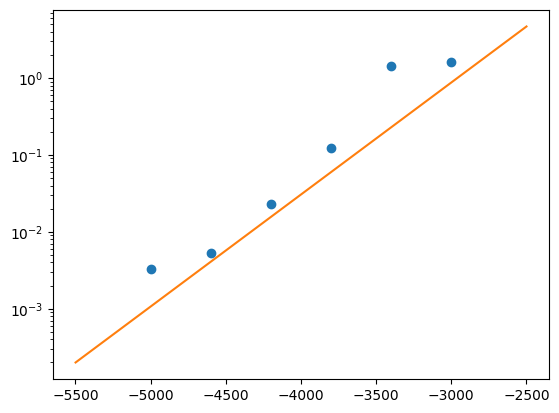

In [105]:
plt.semilogy(-lammps_mu_K.magnitude, lammps_rho_g_cm3.magnitude, 'o')
plt.semilogy(-mu_K.magnitude, rho_g_cm3.magnitude)

# GOMC data

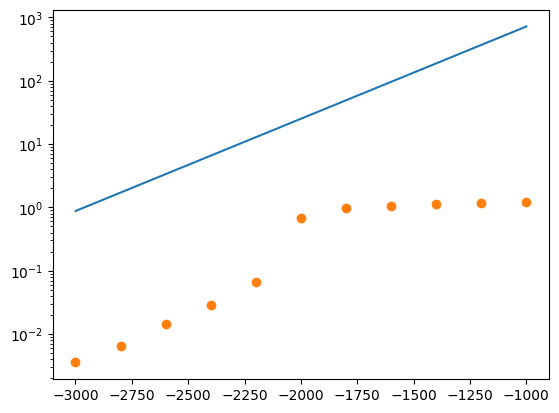

In [135]:


rho_vs_mu_GOMC = []
for mu_K in [1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]:
    mu_kcal_mol = mu_K*0.00198 # kcal/mol
    mu_J = mu_kcal_mol*4.184*1000/6.022e23 # J
    rho_O = np.loadtxt("outputs_mu"+str(mu_K)+"/density_O.dat")
    rho_C = np.loadtxt("outputs_mu"+str(mu_K)+"/density_C.dat")
    rho_CO2 = rho_O+rho_C # g/cm3
    end_rho_H2O = np.mean(rho_CO2[:,1][-2:])
    rho_vs_mu_GOMC.append([mu_kcal_mol, end_rho_H2O, mu_J, mu_K])
rho_vs_mu_GOMC = np.array(rho_vs_mu_GOMC)

plt.semilogy(-rho_vs_mu_GOMC[:,3], rho_vs_mu_GOMC[:,1], 'o')

In [128]:
rho_vs_mu_GOMC[:,0]*4.184

array([ 8.28432 ,  9.941184, 11.598048, 13.254912, 14.911776, 16.56864 ,
       18.225504, 19.882368, 21.539232, 23.196096, 24.85296 ])

In [134]:
rho_vs_mu_GOMC[:,0]

array([1.98 , 2.376, 2.772, 3.168, 3.564, 3.96 , 4.356, 4.752, 5.148,
       5.544, 5.94 ])

In [92]:



stop
rho_ideal_GOMC *= m_g_mol/Na # g/m3
rho_ideal_GOMC /= 100**3 # g/cm3

plt.semilogy(-rho_vs_mu_GOMC[:,0], rho_vs_mu_GOMC[:,1], 'o')
plt.semilogy(-rho_vs_mu_GOMC[:,0], rho_ideal_GOMC, '-')

1000 1.98
1200 2.376
1400 2.772
1600 3.168
1800 3.564
2000 3.96
2200 4.356
2400 4.752
2600 5.148
2800 5.544
3000 5.94


/tmp/ipykernel_1961489/143180878.py:11: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  rho_vs_mu_GOMC = np.array(rho_vs_mu_GOMC)


ValueError: setting an array element with a sequence.

In [94]:
mu_K

3000

# LAMMPS data

In [4]:
rho_vs_mu_LAMMPS = []
for mu_K in [3400, 3600, 3800, 4000, 4200, 4400, 4600]:
    mu_kcal_mol = mu_K*0.00198 # kcal/mol
    mu_J = mu_kcal_mol*4.184*1000/Na # J
    rho_H2O = np.loadtxt("lammps-comparison/outputs_mu"+str(mu_K)+"/density_H2O.dat")
    end_rho_H2O = np.mean(rho_H2O[:,1][-10:])
    rho_vs_mu_LAMMPS.append([mu_kcal_mol, end_rho_H2O, mu_J, mu_K])
rho_vs_mu_LAMMPS = np.array(rho_vs_mu_LAMMPS)

rho_ideal_LAMMPS = np.exp(-rho_vs_mu_LAMMPS[:,2]/(kB*T)) / lbd**3 # molecules per m3
rho_ideal_LAMMPS *= 18/Na # g/m3
rho_ideal_LAMMPS /= 100**3 # g/cm3

FileNotFoundError: lammps-comparison/outputs_mu3400/density_H2O.dat not found.

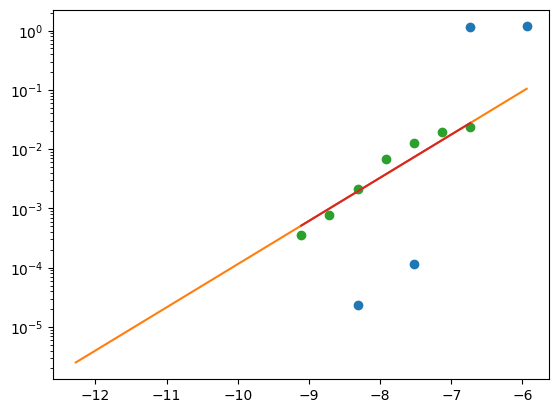

In [ ]:
plt.semilogy(-rho_vs_mu_GOMC[:,0], rho_vs_mu_GOMC[:,1], 'o')
plt.semilogy(-rho_vs_mu_GOMC[:,0], rho_ideal_GOMC, '-')

plt.semilogy(-rho_vs_mu_LAMMPS[:,0], rho_vs_mu_LAMMPS[:,1], 'o')
plt.semilogy(-rho_vs_mu_LAMMPS[:,0], rho_ideal_LAMMPS, '-')